In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import random
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import re
import seaborn as sns

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## LOAD & PREPROCESS DATA

In [3]:
MAX_SAMPLES = 10000

def normalize(s):
    s = s.lower().strip()
    s = re.sub(r"([?.!,¿])", r" \1 ", s)
    s = re.sub(r'[" "]+', " ", s)
    return s

pairs = []

with open("/kaggle/input/datasets/ojasavrathore/spa-data/spa.txt", encoding="utf-8") as f:
    for line in f.readlines()[:MAX_SAMPLES]:
        eng, spa = line.strip().split("\t")
        pairs.append((normalize(eng), normalize(spa)))

train_pairs, temp_pairs = train_test_split(pairs, test_size=0.2)
val_pairs, test_pairs = train_test_split(temp_pairs, test_size=0.5)

## Building Vocabulary

In [4]:
PAD, SOS, EOS = 0, 1, 2

class Vocab:
    def __init__(self):
        self.word2idx = {"<pad>":0, "<sos>":1, "<eos>":2}
        self.idx2word = {0:"<pad>", 1:"<sos>", 2:"<eos>"}
        self.count = 3

    def add_sentence(self, sentence):
        for word in sentence.split():
            if word not in self.word2idx:
                self.word2idx[word] = self.count
                self.idx2word[self.count] = word
                self.count += 1

eng_vocab = Vocab()
spa_vocab = Vocab()

for e, s in train_pairs:
    eng_vocab.add_sentence(e)
    spa_vocab.add_sentence(s)

def encode(sentence, vocab):
    return [vocab.word2idx.get(w,0) for w in sentence.split()] + [EOS]

## Dataset

In [5]:
class TranslationDataset(Dataset):
    def __init__(self, pairs):
        self.pairs = pairs
        
    def __len__(self):
        return len(self.pairs)
    
    def __getitem__(self, idx):
        e, s = self.pairs[idx]
        return torch.tensor(encode(e, eng_vocab)), torch.tensor([SOS] + encode(s, spa_vocab))

def pad_collate(batch):
    src, trg = zip(*batch)
    src = nn.utils.rnn.pad_sequence(src, padding_value=PAD)
    trg = nn.utils.rnn.pad_sequence(trg, padding_value=PAD)
    return src.to(device), trg.to(device)

train_loader = DataLoader(TranslationDataset(train_pairs), batch_size=64, shuffle=True, collate_fn=pad_collate)
val_loader   = DataLoader(TranslationDataset(val_pairs), batch_size=64, collate_fn=pad_collate)
test_loader  = DataLoader(TranslationDataset(test_pairs), batch_size=1, collate_fn=pad_collate)

## Model definations

In [6]:
EMBED_SIZE = 256
HIDDEN_SIZE = 512

class Encoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBED_SIZE)
        self.lstm = nn.LSTM(EMBED_SIZE, HIDDEN_SIZE)
        
    def forward(self, x):
        emb = self.embedding(x)
        outputs, (hidden, cell) = self.lstm(emb)
        return outputs, hidden, cell


class Decoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, EMBED_SIZE)
        self.lstm = nn.LSTM(EMBED_SIZE, HIDDEN_SIZE)
        self.fc = nn.Linear(HIDDEN_SIZE, vocab_size)
        
    def forward(self, x, hidden, cell):
        x = x.unsqueeze(0)
        emb = self.embedding(x)
        output, (hidden, cell) = self.lstm(emb, (hidden, cell))
        pred = self.fc(output.squeeze(0))
        return pred, hidden, cell


class BahdanauAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.W1 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.W2 = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)
        self.V = nn.Linear(HIDDEN_SIZE, 1)

    def forward(self, hidden, encoder_outputs):
        hidden = hidden[-1].unsqueeze(1)
        score = self.V(torch.tanh(self.W1(hidden) + self.W2(encoder_outputs.transpose(0,1))))
        attn_weights = torch.softmax(score, dim=1)
        context = torch.sum(attn_weights * encoder_outputs.transpose(0,1), dim=1)
        return context, attn_weights


class LuongAttention(nn.Module):
    def __init__(self):
        super().__init__()
        self.attn = nn.Linear(HIDDEN_SIZE, HIDDEN_SIZE)

    def forward(self, hidden, encoder_outputs):
        score = torch.bmm(encoder_outputs.transpose(0,1),
                          hidden[-1].unsqueeze(2)).squeeze(2)
        attn_weights = torch.softmax(score, dim=1)
        context = torch.bmm(attn_weights.unsqueeze(1),
                            encoder_outputs.transpose(0,1)).squeeze(1)
        return context, attn_weights


## Training function

In [7]:
def train_model(attention_type=None, epochs=60):
    encoder = Encoder(len(eng_vocab.word2idx)).to(device)
    
    if attention_type:
        attention = attention_type().to(device)
        decoder = Decoder(len(spa_vocab.word2idx)).to(device)
    else:
        attention = None
        decoder = Decoder(len(spa_vocab.word2idx)).to(device)

    optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
    criterion = nn.CrossEntropyLoss(ignore_index=PAD)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        encoder.train()
        decoder.train()
        total_loss = 0

        for src, trg in train_loader:
            optimizer.zero_grad()
            encoder_outputs, hidden, cell = encoder(src)
            input = trg[0]

            loss = 0
            for t in range(1, trg.shape[0]):
                output, hidden, cell = decoder(input, hidden, cell)
                loss += criterion(output, trg[t])
                input = trg[t]

            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        train_losses.append(total_loss / len(train_loader))
        print(f"Epoch {epoch+1}: Loss {train_losses[-1]:.4f}")

    return encoder, decoder, attention, train_losses


## Training

In [8]:
print("Training Vanilla Seq2Seq...")
enc_van, dec_van, _, loss_van = train_model(None)

print("Training Bahdanau Attention...")
enc_bah, dec_bah, attn_bah, loss_bah = train_model(BahdanauAttention)

print("Training Luong Attention...")
enc_luo, dec_luo, attn_luo, loss_luo = train_model(LuongAttention)

Training Vanilla Seq2Seq...
Epoch 1: Loss 24.4983
Epoch 2: Loss 17.4580
Epoch 3: Loss 14.1097
Epoch 4: Loss 11.4375
Epoch 5: Loss 9.1925
Epoch 6: Loss 7.2871
Epoch 7: Loss 5.7368
Epoch 8: Loss 4.4017
Epoch 9: Loss 3.3528
Epoch 10: Loss 2.5638
Epoch 11: Loss 2.0087
Epoch 12: Loss 1.6143
Epoch 13: Loss 1.3742
Epoch 14: Loss 1.2054
Epoch 15: Loss 1.0988
Epoch 16: Loss 1.0242
Epoch 17: Loss 0.9671
Epoch 18: Loss 0.9305
Epoch 19: Loss 0.8939
Epoch 20: Loss 0.8793
Epoch 21: Loss 0.8575
Epoch 22: Loss 0.8393
Epoch 23: Loss 0.8261
Epoch 24: Loss 0.8188
Epoch 25: Loss 0.8244
Epoch 26: Loss 0.8978
Epoch 27: Loss 0.8725
Epoch 28: Loss 0.8070
Epoch 29: Loss 0.7793
Epoch 30: Loss 0.7621
Epoch 31: Loss 0.7636
Epoch 32: Loss 0.7520
Epoch 33: Loss 0.7455
Epoch 34: Loss 0.7283
Epoch 35: Loss 0.7338
Epoch 36: Loss 0.7351
Epoch 37: Loss 0.7326
Epoch 38: Loss 0.7229
Epoch 39: Loss 0.7158
Epoch 40: Loss 0.7157
Epoch 41: Loss 0.7063
Epoch 42: Loss 0.7041
Epoch 43: Loss 0.7018
Epoch 44: Loss 0.6967
Epoch 45:

## Training Loss Plot

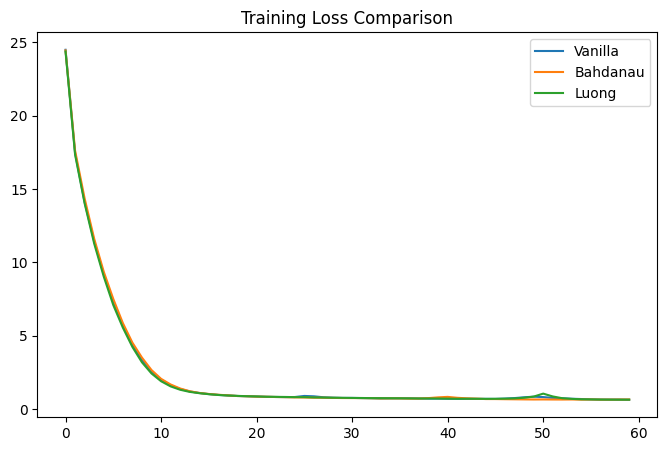

In [9]:
plt.figure(figsize=(8,5))
plt.plot(loss_van, label="Vanilla")
plt.plot(loss_bah, label="Bahdanau")
plt.plot(loss_luo, label="Luong")
plt.legend()
plt.title("Training Loss Comparison")
plt.show()

## BLEU Evaluation

In [10]:

def evaluate_bleu(encoder, decoder):
    encoder.eval()
    decoder.eval()
    smooth = SmoothingFunction().method1
    scores = []

    with torch.no_grad():
        for src, trg in test_loader:
            enc_out, hidden, cell = encoder(src)
            input = torch.tensor([SOS], device=device)
            outputs = []

            for _ in range(20):
                output, hidden, cell = decoder(input, hidden, cell)
                pred = output.argmax(1)
                if pred.item() == EOS:
                    break
                outputs.append(spa_vocab.idx2word[pred.item()])
                input = pred

            reference = [spa_vocab.idx2word[idx.item()] for idx in trg.squeeze()[1:-1]]
            scores.append(sentence_bleu([reference], outputs, smoothing_function=smooth))

    return np.mean(scores)

bleu_van = evaluate_bleu(enc_van, dec_van)
bleu_bah = evaluate_bleu(enc_bah, dec_bah)
bleu_luo = evaluate_bleu(enc_luo, dec_luo)

print("BLEU Scores:")
print("Vanilla:", bleu_van)
print("Bahdanau:", bleu_bah)
print("Luong:", bleu_luo)


BLEU Scores:
Vanilla: 0.19277063772805952
Bahdanau: 0.20101753168106867
Luong: 0.1971571852345878


##  BLEU BAR GRAPH

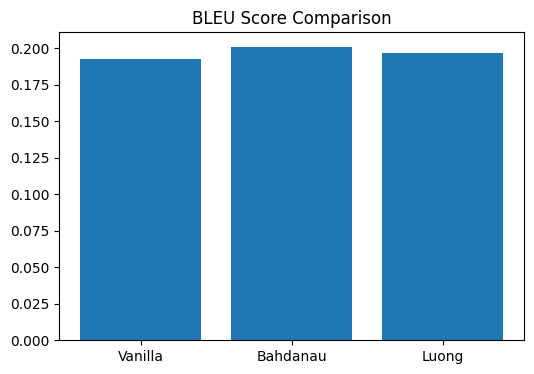

In [11]:
plt.figure(figsize=(6,4))
plt.bar(["Vanilla","Bahdanau","Luong"],
        [bleu_van, bleu_bah, bleu_luo])
plt.title("BLEU Score Comparison")
plt.show()
